# Spatial Map of Bunkers Storm Motion

## Setup

In [16]:
# Import statements

import xarray as xr
import matplotlib.pyplot as plt
from typing import List
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
from scipy import stats
from scipy.ndimage import label
import matplotlib.colors as mcolors
import matplotlib.patches as patches

# Set default style to dark background because I like it better
plt.style.use("dark_background")
plt.rcParams["hatch.linewidth"] = 0.3


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    elif init == 17:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-01 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})

def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


In [3]:
# Read in 20-23Z initializations
wofs_all = [get_wofs_all(n) for n in range(20,24,1)]

# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)


In [4]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_aoi]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]

# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

# Select wet and dry members
wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]


## Plot

In [12]:
# Extract bunkers storm motion vector
bu_wet = get_field(
    wofs_wet, "bunk_r_u", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init
).stack(run=("init", "ne")).squeeze()
bu_dry = get_field(
    wofs_dry, "bunk_r_u", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init
).stack(run=("init", "ne")).squeeze()

# Extract bunkers storm motion vector
bv_wet = get_field(
    wofs_wet, "bunk_r_v", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init
).stack(run=("init", "ne")).squeeze()
bv_dry = get_field(
    wofs_dry, "bunk_r_v", "2021-09-02 01:00:00", "2021-09-02 01:00:00", init
).stack(run=("init", "ne")).squeeze()



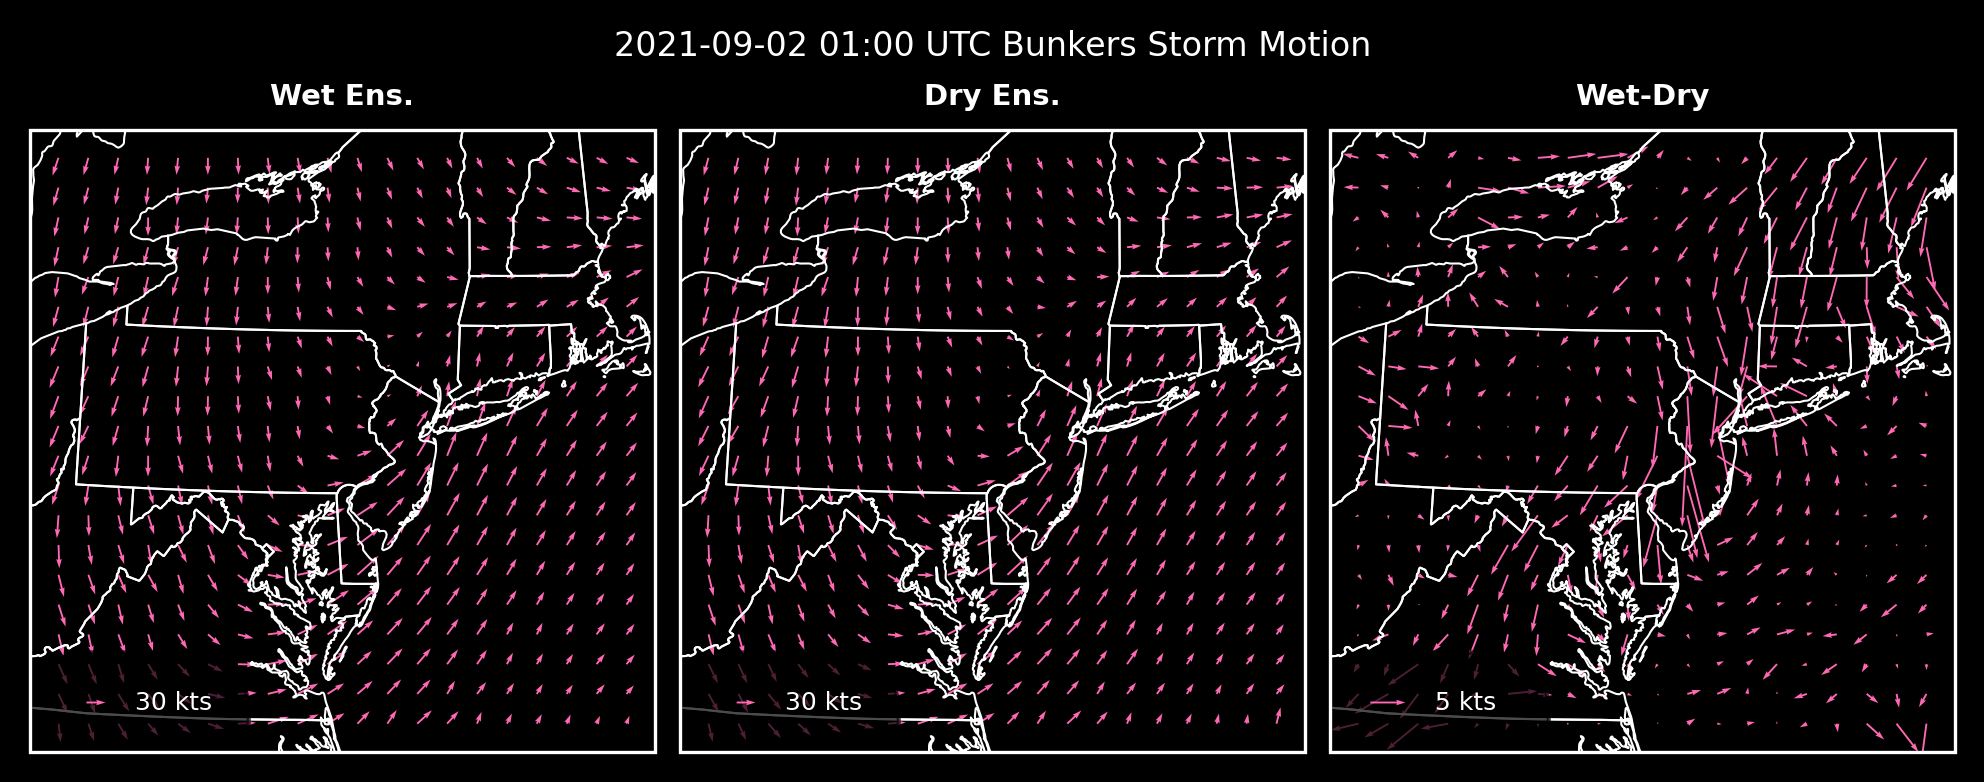

In [24]:
titles = ["Wet Ens.","Dry Ens.","Wet-Dry"]

# Take every 15th lat and lon values
lon_quiv = lon.values[::15,::15]
lat_quiv = lat.values[::15,::15]

us = [bu_wet,bu_dry,bu_wet-bu_dry]
vs = [bv_wet,bv_dry,bv_wet-bv_dry]

fig, axes = plt.subplots(
    1,
    3,
    figsize=(6.5, 2.6),
    dpi=300,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i,ax in enumerate(axes.flat): # type: ignore
    q = ax.quiver(
        lon_quiv,
        lat_quiv,
        us[i].mean(dim="run").values[::15,::15],
        vs[i].mean(dim="run").values[::15,::15],
        transform=ccrs.PlateCarree(),
        # scale=scales[i],
        color="hotpink",
    )

    # add state boundaries
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="white")

    # Add title
    ax.set_title(titles[i],fontsize=7,fontweight="bold")

    # Add a reference vector with a background rectangle
    bbox = patches.FancyBboxPatch((0.1, 0.05), 0.15, 0.01,
                                  boxstyle="round,pad=0.1",
                                  transform=ax.transAxes,
                                  color='black',
                                  alpha=0.7,
                                  zorder=2)
    ax.add_patch(bbox)
    if(i in [0,1]):
        qk = ax.quiverkey(q, 0.12, 0.08, 30, '30 kts', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='hotpink')
    else:
        qk = ax.quiverkey(q, 0.12, 0.08, 5, '5 kts', labelpos='E', coordinates='axes', fontproperties={'size': 6}, color='hotpink')
    qk.set_zorder(3)

# Set suptitle
plt.suptitle("2021-09-02 01:00 UTC Bunkers Storm Motion",fontsize=8)

plt.show()